In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

def load_and_prepare_data():
	"""
    Load and prepare Formula 1 datasets for model training
    """
	# Load datasets
	circuits = pd.read_csv("data/circuits.csv", encoding="ISO-8859-1").drop(columns=['url'])
	constructors = pd.read_csv("data/constructors.csv").drop(columns=['url'])
	drivers = pd.read_csv("data/drivers.csv", encoding="ISO-8859-1").drop(columns=['url'])
	races = pd.read_csv("data/races.csv").drop(columns=['url'])
	results = pd.read_csv("data/results.csv")

	# Date parsing
	drivers['dob'] = pd.to_datetime(drivers['dob'], format='%d/%m/%Y', errors='coerce')
	races['date'] = pd.to_datetime(races['date'], errors='coerce')

	# Merge datasets
	merged_data = results.merge(races[['raceId', 'year', 'circuitId']], on='raceId')
	merged_data = merged_data.merge(drivers[['driverId', 'dob', 'nationality']], on='driverId')
	merged_data = merged_data.merge(constructors[['constructorId', 'name', 'nationality']], on='constructorId')
	merged_data = merged_data.merge(circuits[['circuitId', 'name', 'country']], on='circuitId')

	# Feature engineering
	merged_data['driver_age'] = merged_data['year'] - merged_data['dob'].dt.year

	# Select features
	features = [
		'year', 'grid', 'driver_age',
		'constructorId', 'circuitId',
		'nationality_x'  # Driver nationality
	]

	# Prepare X and y
	X = merged_data[features]
	y = merged_data['points']

	return X, y, merged_data

def create_preprocessing_pipeline():
	"""
    Create a comprehensive preprocessing pipeline
    """
	# Numeric features
	numeric_features = ['year', 'grid', 'driver_age']

	# Categorical features
	categorical_features = [
		'constructorId', 'circuitId',
		'nationality_x'
	]

	# Preprocessing for numeric features
	numeric_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='median')),
		('scaler', StandardScaler())
	])

	# Preprocessing for categorical features
	categorical_transformer = Pipeline(steps=[
		('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
		('onehot', OneHotEncoder(handle_unknown='ignore'))
	])

	# Combine preprocessing steps
	preprocessor = ColumnTransformer(
		transformers=[
			('num', numeric_transformer, numeric_features),
			('cat', categorical_transformer, categorical_features)
		])

	return preprocessor

def train_performance_prediction_model(test_size=0.2, random_state=42):
	"""
    Train and evaluate multiple models for F1 performance prediction
    """
	# Load and prepare data
	X, y, merged_data = load_and_prepare_data()

	# Split the data
	X_train, X_test, y_train, y_test = train_test_split(
		X, y, test_size=test_size, random_state=random_state
	)

	# Create preprocessing pipeline
	preprocessor = create_preprocessing_pipeline()

	# Define models to test
	models = {
		'Random Forest': RandomForestRegressor(n_estimators=100, random_state=random_state),
		'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=random_state)
	}

	# Results storage
	model_results = {}
	fitted_pipeline = None

	# Train and evaluate each model
	for name, model in models.items():
		# Create full pipeline
		pipeline = Pipeline([
			('preprocessor', preprocessor),
			('regressor', model)
		])

		# Train the model
		pipeline.fit(X_train, y_train)

		# Make predictions
		y_pred = pipeline.predict(X_test)

		# Evaluate the model
		mse = mean_squared_error(y_test, y_pred)
		r2 = r2_score(y_test, y_pred)
		mae = mean_absolute_error(y_test, y_pred)

		# Perform cross-validation
		cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')

		# Store results
		model_results[name] = {
			'Mean Squared Error': mse,
			'R-squared': r2,
			'Mean Absolute Error': mae,
			'Cross-Validation R2': (cv_scores.mean(), cv_scores.std())
		}

		# Print results
		print(f"\n{name} Model Performance:")
		for metric, value in model_results[name].items():
			print(f"{metric}: {value}")

		fitted_pipeline = pipeline  # The last model that was trained

	return models, model_results, X_test, y_test, fitted_pipeline

def feature_importance(fitted_pipeline):
	"""
    Extract and print feature importances from a fitted pipeline
    """
	try:
		# Get the fitted regressor from the pipeline
		regressor = fitted_pipeline.named_steps['regressor']

		# Get the preprocessor from the pipeline
		preprocessor = fitted_pipeline.named_steps['preprocessor']

		# Get feature names after preprocessing
		feature_names = (
				preprocessor
				.named_transformers_['num'].get_feature_names_out().tolist() +
				preprocessor
				.named_transformers_['cat'].get_feature_names_out().tolist()
		)

		# Get feature importances
		importances = regressor.feature_importances_

		# Create a DataFrame of feature importances
		feature_importance_df = pd.DataFrame({
			'feature': feature_names,
			'importance': importances
		}).sort_values('importance', ascending=False)

		print("\nFeature Importances:")
		print(feature_importance_df)

		return feature_importance_df

	except Exception as e:
		print(f"Error extracting feature importances: {e}")
		return None


models, model_results, X_test, y_test, fitted_pipeline = train_performance_prediction_model()

# Extract feature importances
feature_importance(fitted_pipeline)


Random Forest Model Performance:
Mean Squared Error: 6.482414989028595
R-squared: 0.46381468609468524
Mean Absolute Error: 1.3587626156433978
Cross-Validation R2: (np.float64(0.23520567292320899), np.float64(0.0647537911904432))

Gradient Boosting Model Performance:
Mean Squared Error: 5.897794471703627
R-squared: 0.5121708829947464
Mean Absolute Error: 1.389068906461524
Cross-Validation R2: (np.float64(0.28732627891950424), np.float64(0.0808797084748351))

Feature Importances:
               feature  importance
0                 year    0.490868
1                 grid    0.424890
8      constructorId_6    0.018348
127  constructorId_131    0.016348
11     constructorId_9    0.011096
..                 ...         ...
155  constructorId_162    0.000000
156  constructorId_163    0.000000
18    constructorId_16    0.000000
69    constructorId_69    0.000000
167  constructorId_175    0.000000

[314 rows x 2 columns]


,feature,importance
0,year,0.490868
1,grid,0.424890
8,constructorId_6,0.018348
127,constructorId_131,0.016348
11,constructorId_9,0.011096
...,...,...
155,constructorId_162,0.000000
156,constructorId_163,0.000000
18,constructorId_16,0.000000
69,constructorId_69,0.000000


In [54]:
# 1. Make a single prediction
def make_prediction(fitted_pipeline, year, grid, constructor_id):
	"""
    Make a prediction for a single race scenario
    """
	# Create a sample input DataFrame
	sample_input = pd.DataFrame({
		'year': [year],
		'grid': [grid],
		'driver_age': [25],  # You can add this as parameter if needed
		'constructorId': [constructor_id],
		'circuitId': [1],    # You can add this as parameter if needed
		'nationality_x': ['British']  # You can add this as parameter if needed
	})

	# Make prediction
	predicted_points = fitted_pipeline.predict(sample_input)
	return predicted_points[0]

# 2. Compare actual vs predicted for test set
def evaluate_predictions(fitted_pipeline, X_test, y_test, n_samples=10):
	"""
    Compare actual vs predicted values for a subset of the test data
    """
	# Get predictions for test set
	y_pred = fitted_pipeline.predict(X_test)

	# Create comparison DataFrame
	comparison = pd.DataFrame({
		'Actual Points': y_test,
		'Predicted Points': y_pred,
		'Difference': abs(y_test - y_pred)
	})

	# Add original features
	for col in X_test.columns:
		comparison[col] = X_test[col]

	# Sort by largest differences
	comparison = comparison.sort_values('Difference', ascending=False)

	print("\nSample Predictions vs Actual:")
	print(comparison.head(n_samples))

	return comparison

# 3. Test different scenarios
def test_scenarios(fitted_pipeline):
	"""
    Test various racing scenarios
    """
	scenarios = [
		{'year': 2023, 'grid': 1, 'constructor_id': 1, 'desc': 'Pole Position'},
		{'year': 2023, 'grid': 10, 'constructor_id': 1, 'desc': 'Mid Grid'},
		{'year': 2023, 'grid': 20, 'constructor_id': 1, 'desc': 'Back of Grid'},
	]

	print("\nTesting Different Scenarios:")
	for scenario in scenarios:
		points = make_prediction(
			fitted_pipeline,
			scenario['year'],
			scenario['grid'],
			scenario['constructor_id']
		)
		print(f"{scenario['desc']}: Predicted Points = {points:.2f}")


# 1. Make a single prediction
print("\nSingle Prediction:")
predicted_points = make_prediction(fitted_pipeline, 2023, 1, 1)
print(f"Predicted points for pole position in 2023: {predicted_points:.2f}")

# 2. Evaluate test set predictions
comparison = evaluate_predictions(fitted_pipeline, X_test, y_test)

# 3. Test different scenarios
test_scenarios(fitted_pipeline)


Single Prediction:
Predicted points for pole position in 2023: 15.95

Sample Predictions vs Actual:
       Actual Points  Predicted Points  Difference  year  grid  driver_age  \
22527            0.0         21.649059   21.649059  2014     1        29.0   
22828            0.0         20.894494   20.894494  2015     1        30.0   
22320            0.0         20.183485   20.183485  2014     1        29.0   
23259            0.0         20.143883   20.143883  2016     1        31.0   
23514           25.0          4.954142   20.045858  2017    10        28.0   
21709           25.0          6.670153   18.329847  2013     7        34.0   
22304           18.0          0.941251   17.058749  2014    14        25.0   
22259           25.0          8.362177   16.637823  2014     6        25.0   
21254           18.0          2.664171   15.335829  2012     9        22.0   
21058            0.0         14.539383   14.539383  2011     2        26.0   

       constructorId  circuitId national


Random Forest Model Performance:
Mean Squared Error: 6.482414989028595
R-squared: 0.46381468609468524
Mean Absolute Error: 1.3587626156433978
Cross-Validation R2: (np.float64(0.23520567292320899), np.float64(0.0647537911904432))

Gradient Boosting Model Performance:
Mean Squared Error: 5.897794471703627
R-squared: 0.5121708829947464
Mean Absolute Error: 1.389068906461524
Cross-Validation R2: (np.float64(0.28732627891950424), np.float64(0.0808797084748351))

Feature Importances:
               feature  importance
0                 year    0.490868
1                 grid    0.424890
8      constructorId_6    0.018348
127  constructorId_131    0.016348
11     constructorId_9    0.011096
..                 ...         ...
155  constructorId_162    0.000000
156  constructorId_163    0.000000
18    constructorId_16    0.000000
69    constructorId_69    0.000000
167  constructorId_175    0.000000

[314 rows x 2 columns]


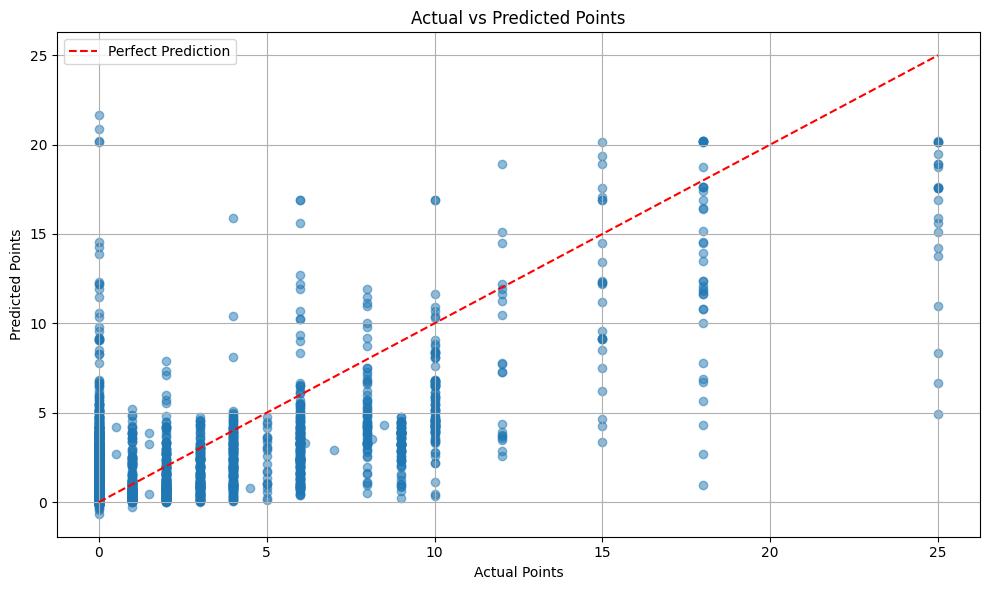

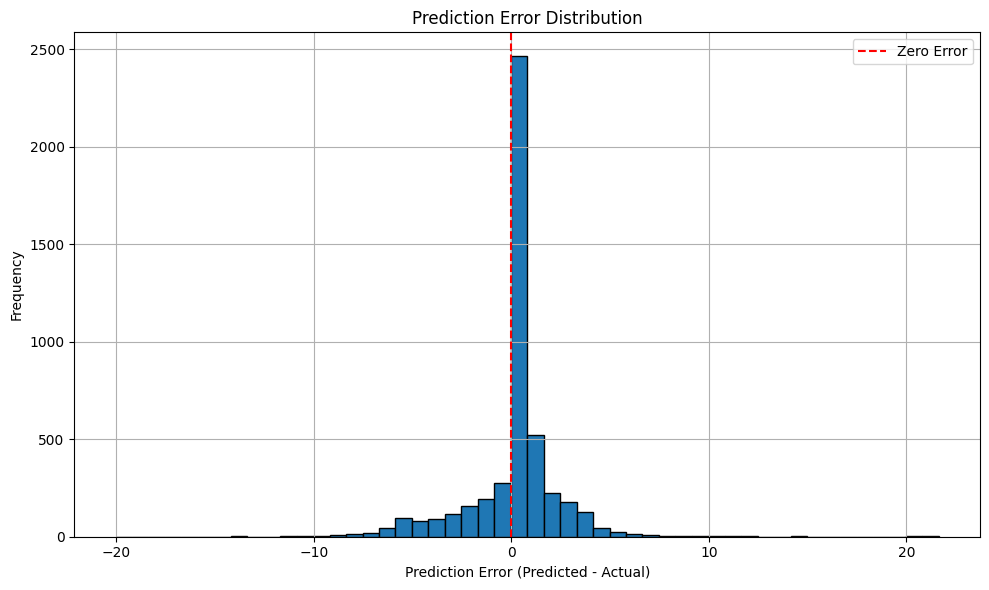

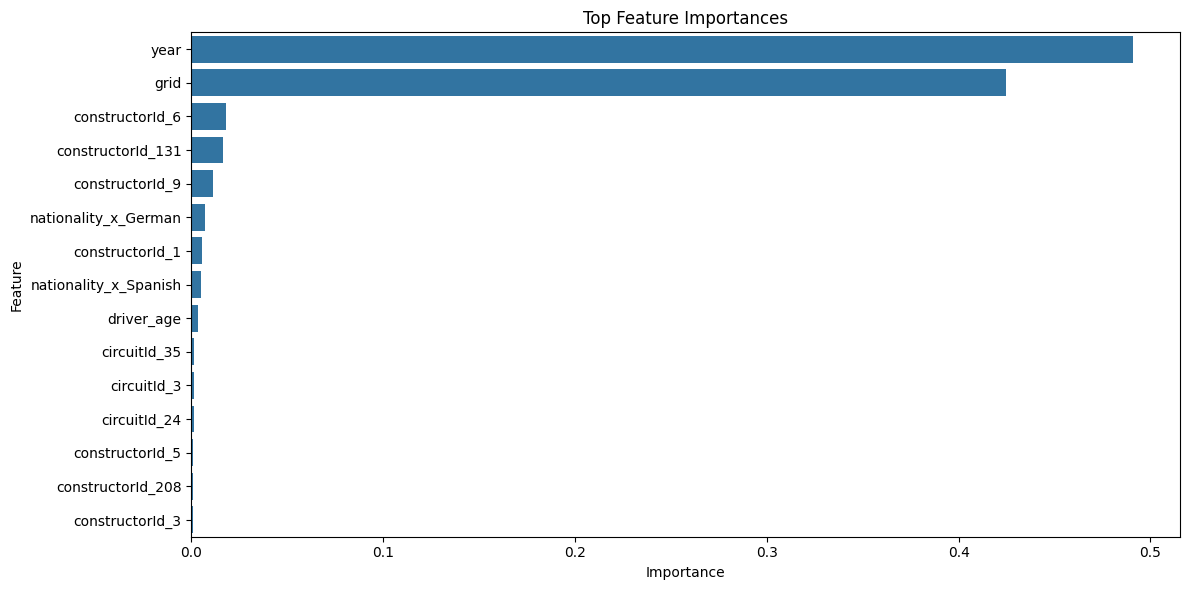

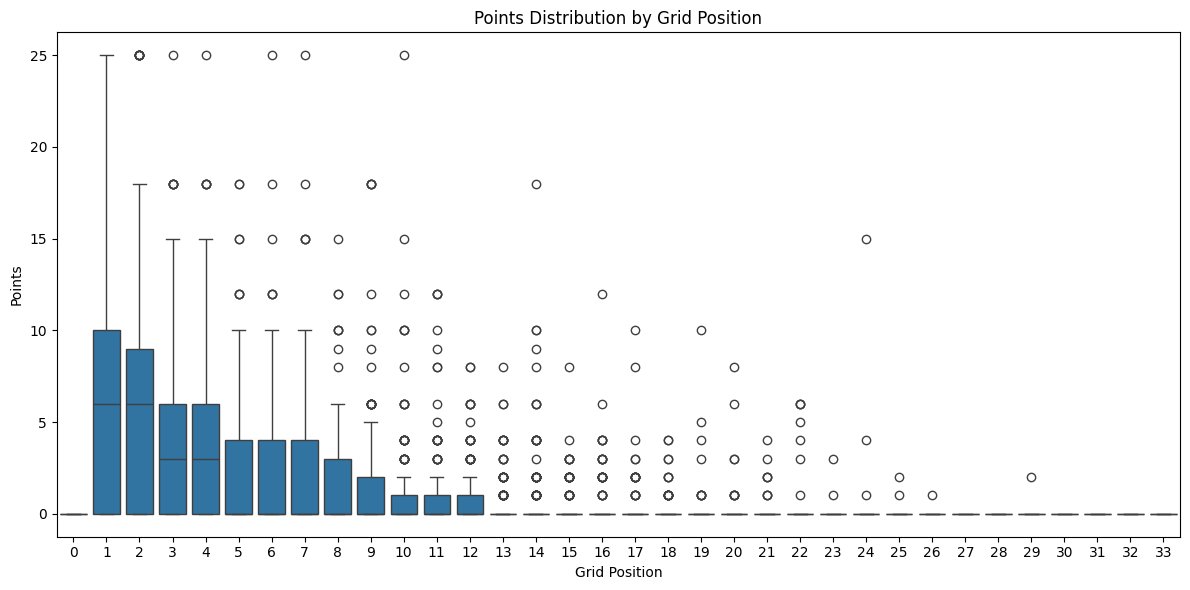

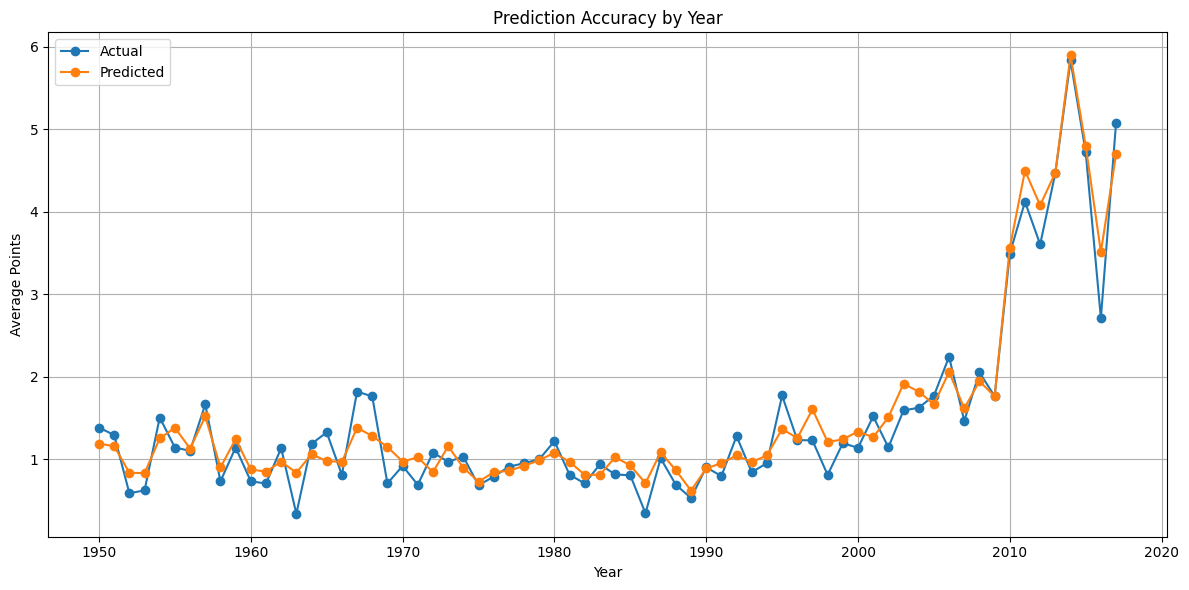

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_actual_vs_predicted(y_test, y_pred, title="Actual vs Predicted Points"):
	"""
    Create a scatter plot of actual vs predicted points
    """
	plt.figure(figsize=(10, 6))
	plt.scatter(y_test, y_pred, alpha=0.5)

	# Add perfect prediction line
	max_value = max(max(y_test), max(y_pred))
	plt.plot([0, max_value], [0, max_value], 'r--', label='Perfect Prediction')

	plt.xlabel('Actual Points')
	plt.ylabel('Predicted Points')
	plt.title(title)
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

def plot_error_distribution(y_test, y_pred, title="Prediction Error Distribution"):
	"""
    Create a histogram of prediction errors
    """
	errors = y_pred - y_test

	plt.figure(figsize=(10, 6))
	plt.hist(errors, bins=50, edgecolor='black')
	plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')

	plt.xlabel('Prediction Error (Predicted - Actual)')
	plt.ylabel('Frequency')
	plt.title(title)
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

def plot_feature_importance(feature_importance_df, title="Top Feature Importances"):
	"""
    Create a bar plot of feature importances
    """
	# Get top 15 features
	top_features = feature_importance_df.head(15)

	plt.figure(figsize=(12, 6))
	sns.barplot(data=top_features, x='importance', y='feature')

	plt.xlabel('Importance')
	plt.ylabel('Feature')
	plt.title(title)
	plt.tight_layout()
	plt.show()

def plot_points_by_grid(X_test, y_test, title="Points Distribution by Grid Position"):
	"""
    Create a box plot of points distribution by grid position
    """
	# Combine grid positions and points
	grid_points = pd.DataFrame({
		'Grid Position': X_test['grid'],
		'Points': y_test
	})

	plt.figure(figsize=(12, 6))
	sns.boxplot(data=grid_points, x='Grid Position', y='Points')

	plt.xlabel('Grid Position')
	plt.ylabel('Points')
	plt.title(title)
	plt.tight_layout()
	plt.show()

def plot_prediction_by_year(X_test, y_test, y_pred, title="Prediction Accuracy by Year"):
	"""
    Create a line plot showing prediction accuracy over years
    """
	results_by_year = pd.DataFrame({
		'Year': X_test['year'],
		'Actual': y_test,
		'Predicted': y_pred
	})

	yearly_mean = results_by_year.groupby('Year').mean()

	plt.figure(figsize=(12, 6))
	plt.plot(yearly_mean.index, yearly_mean['Actual'], label='Actual', marker='o')
	plt.plot(yearly_mean.index, yearly_mean['Predicted'], label='Predicted', marker='o')

	plt.xlabel('Year')
	plt.ylabel('Average Points')
	plt.title(title)
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

def create_all_visualizations(X_test, y_test, fitted_pipeline, feature_importance_df):
	"""
    Generate all visualizations
    """
	# Get predictions
	y_pred = fitted_pipeline.predict(X_test)

	# Create all plots
	plot_actual_vs_predicted(y_test, y_pred)
	plot_error_distribution(y_test, y_pred)
	plot_feature_importance(feature_importance_df)
	plot_points_by_grid(X_test, y_test)
	plot_prediction_by_year(X_test, y_test, y_pred)

# Usage example:
if __name__ == "__main__":
	# Assuming you have your model results from previous training
	models, results, X_test, y_test, fitted_pipeline = train_performance_prediction_model()

	# Get predictions for test set
	y_pred = fitted_pipeline.predict(X_test)

	# Get feature importances
	feature_importance_df = feature_importance(fitted_pipeline)

	# Create all visualizations
	create_all_visualizations(X_test, y_test, fitted_pipeline, feature_importance_df)